# This Notebook is Model Testing for SubGroup instances of Classification Codes

In [253]:
# Import all necessary packages

import ast
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt

from prettytable import PrettyTable

# All Data

The subsequent section will test the performance of the following models on the whole dataset:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks


In [237]:
# Load the data
df = pd.read_csv('Data_Preprocessed_SubGroup.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,"[G06N5/02, G06N20/00]"
1,imag sens devic imag sens devic includ substra...,[H01L27/146]
2,antigen specif immunotherapi covid19 fusion pr...,"[A61K39/215, A61K38/00, A61K39/00, A61P31/14, ..."
3,secur deescal data access concept technolog di...,[G06F21/62]
4,system method secur cloudbas physiolog data pr...,"[A61B90/90, A61B5/00, A61B5/25, A61B5/259, A61..."


In [238]:
# As most multi-label classifiers requres each class to have multiple instances.
# All codes which appear less than 5 times will be removed

for i in range(10):

    # Determine the codes to be removed
    unique_codes = df['Classification Codes'].explode().value_counts()
    codes_to_remove = unique_codes[unique_codes < 5 ].index.tolist()

    # Remove rows with empty 'Classification Codes' column
    df = df.dropna(subset=['Classification Codes'])

    # Remove codes in the list codes_to_remove
    df['CodeCount'] = df['Classification Codes'].apply(lambda codes: sum(code in codes_to_remove for code in codes))
    df = df[df['CodeCount'] == 0].drop(columns=['CodeCount'])

In [240]:
# Now all codes will have a minimum of 5 instances
print(unique_codes)

A61B5/00      1507
A61B17/00     1039
G06T7/00       770
A61B90/00      695
H04W72/04      586
              ... 
A61F2/88         5
A61K39/145       5
G08B23/00        5
A61B3/12         5
G06F40/56        5
Name: Classification Codes, Length: 1091, dtype: int64


In [241]:
# Encode "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

Unique Classes: ['A01N1/02' 'A41C3/04' 'A45D26/00' ... 'H05B47/105' 'H05B47/11'
 'H05B47/175']
X_train shape: (10594, 52400)
y_train shape: (7132, 1091)


In [242]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [243]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.026345291479820628
Hamming Loss: 0.005006309264960356


## Random Forest Classifier 


In [244]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.013452914798206279
Hamming Loss: 0.004296260065024477


## Support Vector Machine  (One vs Rest)


In [245]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.021860986547085202
Hamming Loss: 0.006029252793956258


## Deep Neural Networks 

In [247]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build basic deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
179/179 [==============================] - 4s 17ms/step - loss: 0.0850 - accuracy: 0.1495 - val_loss: 0.0298 - val_accuracy: 0.2130
Epoch 2/10
179/179 [==============================] - 3s 14ms/step - loss: 0.0262 - accuracy: 0.2368 - val_loss: 0.0246 - val_accuracy: 0.2712
Epoch 3/10
179/179 [==============================] - 3s 14ms/step - loss: 0.0202 - accuracy: 0.2838 - val_loss: 0.0220 - val_accuracy: 0.3041
Epoch 4/10
179/179 [==============================] - 3s 14ms/step - loss: 0.0165 - accuracy: 0.3245 - val_loss: 0.0206 - val_accuracy: 0.3224
Epoch 5/10
179/179 [==============================] - 2s 14ms/step - loss: 0.0142 - accuracy: 0.3516 - val_loss: 0.0199 - val_accuracy: 0.3189
Epoch 6/10
179/179 [==============================] - 2s 13ms/step - loss: 0.0125 - accuracy: 0.3530 - val_loss: 0.0195 - val_accuracy: 0.3146
Epoch 7/10
179/179 [==============================] - 2s 14ms/step - loss: 0.0113 - accuracy: 0.3637 - val_loss: 0.0194 - val_accuracy: 0.2817

In [248]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.1495, Validation Accuracy: 0.2130
Epoch 2 - Accuracy: 0.2368, Validation Accuracy: 0.2712
Epoch 3 - Accuracy: 0.2838, Validation Accuracy: 0.3041
Epoch 4 - Accuracy: 0.3245, Validation Accuracy: 0.3224
Epoch 5 - Accuracy: 0.3516, Validation Accuracy: 0.3189
Epoch 6 - Accuracy: 0.3530, Validation Accuracy: 0.3146
Epoch 7 - Accuracy: 0.3637, Validation Accuracy: 0.2817
Epoch 8 - Accuracy: 0.3706, Validation Accuracy: 0.3083
Epoch 9 - Accuracy: 0.3814, Validation Accuracy: 0.2887
Epoch 10 - Accuracy: 0.3781, Validation Accuracy: 0.2719

Hamming Loss: 0.004357914120011673


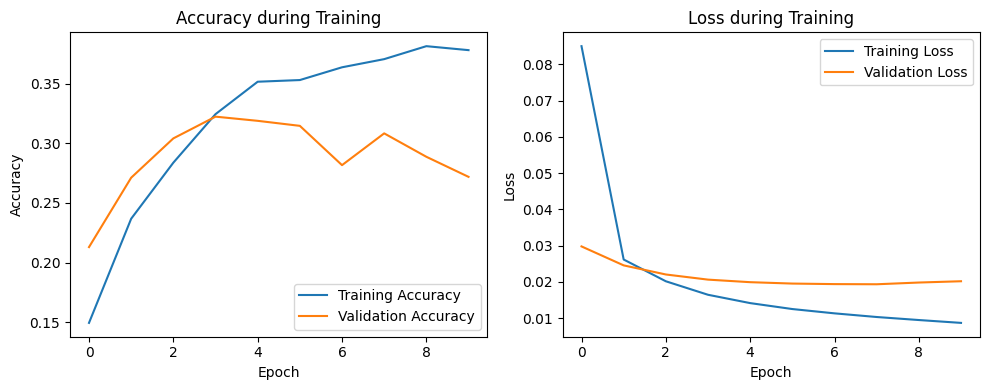

In [249]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Top 18 Codes

The subsequent section will utalise a subset of the whole data. This subset only contains the top 18 codes by frequency these codes are:

- A61B5/00     
- A61B17/00  
- A61B90/00 
- G06T7/00      
- G06N20/00     
- H04W72/04  
- A61K9/00     
- G06K9/62 
- G06K9/00  
- G16H10/60
- A61B6/00
- G06N3/08 
- H04L5/00  
- A61B18/00
- A61K45/06  
- G16H50/20
- A61B1/00 
- A61K39/00

The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [141]:
# Load the data for top 18 codes
df = pd.read_csv('Data_Preprocessed_SubGroup_Top18.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N20/00]
1,antigen specif immunotherapi covid19 fusion pr...,[A61K39/00]
2,system method secur cloudbas physiolog data pr...,"[A61B5/00, G16H10/60]"
3,collim detector base medic imag system medic i...,[A61B6/00]
4,method devic determin relat two entiti method ...,"[G06K9/62, G06N3/08]"


In [142]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [143]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##  Logistic Regression

In [79]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.31212121212121213
Hamming Loss: 0.06767676767676768


## Random Forest 

In [84]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.22727272727272727
Hamming Loss: 0.06428170594837261


## Support Vector Machine  (One vs Rest)


In [76]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.2722222222222222
Hamming Loss: 0.07645903479236812


## Deep Neural Networks 

In [148]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
198/198 [==============================] - 6s 29ms/step - loss: 0.2551 - accuracy: 0.4230 - val_loss: 0.1567 - val_accuracy: 0.5795
Epoch 2/10
198/198 [==============================] - 5s 24ms/step - loss: 0.1117 - accuracy: 0.6726 - val_loss: 0.1548 - val_accuracy: 0.5789
Epoch 3/10
198/198 [==============================] - 4s 18ms/step - loss: 0.0703 - accuracy: 0.7523 - val_loss: 0.1661 - val_accuracy: 0.5701
Epoch 4/10
198/198 [==============================] - 4s 19ms/step - loss: 0.0454 - accuracy: 0.7932 - val_loss: 0.1823 - val_accuracy: 0.5833
Epoch 5/10
198/198 [==============================] - 4s 21ms/step - loss: 0.0289 - accuracy: 0.8112 - val_loss: 0.2051 - val_accuracy: 0.5701
Epoch 6/10
198/198 [==============================] - 4s 18ms/step - loss: 0.0190 - accuracy: 0.8170 - val_loss: 0.2246 - val_accuracy: 0.5682
Epoch 7/10
198/198 [==============================] - 4s 18ms/step - loss: 0.0129 - accuracy: 0.8151 - val_loss: 0.2511 - val_accuracy: 0.5676

In [160]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.4230, Validation Accuracy: 0.5795
Epoch 2 - Accuracy: 0.6726, Validation Accuracy: 0.5789
Epoch 3 - Accuracy: 0.7523, Validation Accuracy: 0.5701
Epoch 4 - Accuracy: 0.7932, Validation Accuracy: 0.5833
Epoch 5 - Accuracy: 0.8112, Validation Accuracy: 0.5701
Epoch 6 - Accuracy: 0.8170, Validation Accuracy: 0.5682
Epoch 7 - Accuracy: 0.8151, Validation Accuracy: 0.5676
Epoch 8 - Accuracy: 0.8195, Validation Accuracy: 0.5694
Epoch 9 - Accuracy: 0.8192, Validation Accuracy: 0.5707
Epoch 10 - Accuracy: 0.8266, Validation Accuracy: 0.5638

Hamming Loss: 0.059876543209876544


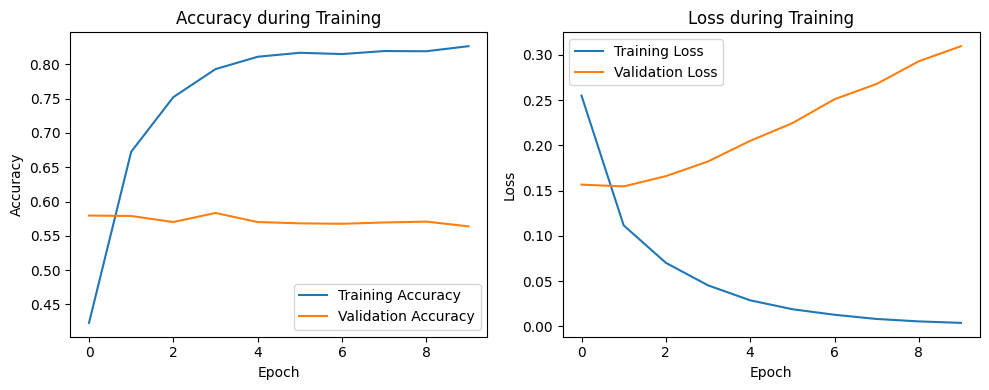

In [152]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Selected 7 Codes

The subsequent section will utalise a smaller subset of the whole data. This subset only contains selected 7 codes by Beyond Blood, these codes are:

- A61B5/00     
- A61B17/00      
- G06N20/00
- G06K9/00  
- G16H10/60
- A61B6/00
- A61B1/00 


The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [161]:
# Load the data for selected 7 codes by Beyond Blood
df = pd.read_csv('Data_Preprocessed_SubGroup_Selected7.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N20/00]
1,system method secur cloudbas physiolog data pr...,"[A61B5/00, G16H10/60]"
2,collim detector base medic imag system medic i...,[A61B6/00]
3,insul pedicl access system relat method pedicl...,"[A61B5/00, A61B17/00]"
4,ingest event marker data framework ingest even...,"[A61B5/00, G16H10/60]"


In [162]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [163]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [164]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.48352553542009885
Hamming Loss: 0.11061426217933631


## Random Forest 

In [165]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.4514003294892916
Hamming Loss: 0.10331842786538009


## Support Vector Machine  (One vs Rest)


In [166]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.44810543657331137
Hamming Loss: 0.12167568839726994


## Deep Neural Networks

In [167]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
122/122 [==============================] - 3s 13ms/step - loss: 0.2775 - accuracy: 0.6656 - val_loss: 0.2330 - val_accuracy: 0.7137
Epoch 2/10
122/122 [==============================] - 1s 8ms/step - loss: 0.1112 - accuracy: 0.8617 - val_loss: 0.2421 - val_accuracy: 0.7240
Epoch 3/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0519 - accuracy: 0.9171 - val_loss: 0.2707 - val_accuracy: 0.7209
Epoch 4/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0244 - accuracy: 0.9312 - val_loss: 0.3154 - val_accuracy: 0.7075
Epoch 5/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0124 - accuracy: 0.9312 - val_loss: 0.3616 - val_accuracy: 0.7312
Epoch 6/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0079 - accuracy: 0.9323 - val_loss: 0.3931 - val_accuracy: 0.7209
Epoch 7/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0049 - accuracy: 0.9366 - val_loss: 0.4289 - val_accuracy: 0.7240
Epoch

In [168]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.6656, Validation Accuracy: 0.7137
Epoch 2 - Accuracy: 0.8617, Validation Accuracy: 0.7240
Epoch 3 - Accuracy: 0.9171, Validation Accuracy: 0.7209
Epoch 4 - Accuracy: 0.9312, Validation Accuracy: 0.7075
Epoch 5 - Accuracy: 0.9312, Validation Accuracy: 0.7312
Epoch 6 - Accuracy: 0.9323, Validation Accuracy: 0.7209
Epoch 7 - Accuracy: 0.9366, Validation Accuracy: 0.7240
Epoch 8 - Accuracy: 0.9325, Validation Accuracy: 0.7147
Epoch 9 - Accuracy: 0.9371, Validation Accuracy: 0.7188
Epoch 10 - Accuracy: 0.9364, Validation Accuracy: 0.7178

Hamming Loss: 0.09237467639444576


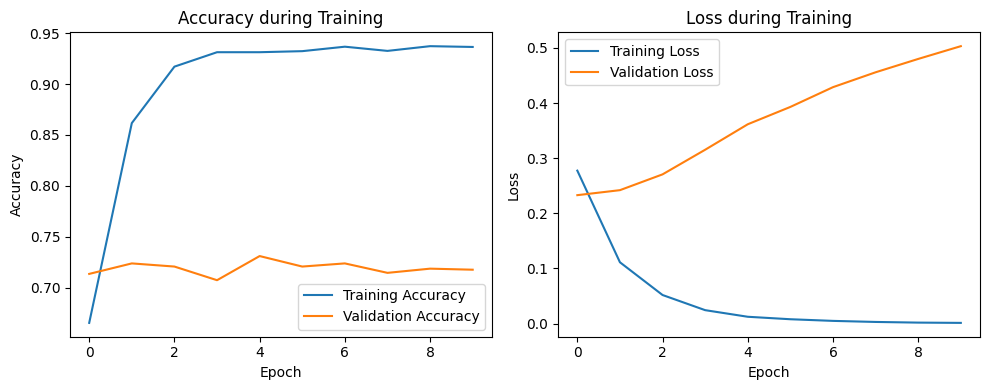

In [169]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Results

This section presents all results from the model into a table format for ease of visualisation

In [254]:
def results_table(data):
    table = PrettyTable()
    
    # Define column headers
    table.field_names = ["Model", "Accuracy", "Hamming Loss"]
    
    # Add data
    for row in data:
        table.add_row(row)
        
    # Align data
    table.align["Model"] = "l"
    table.align["Accuracy"] = "r"
    table.align["Hamming Loss"] = "r"
    table.float_format = ".4"

    print(table)

In [255]:
# Data for the table
data_all = [
    ["Logistic Regression", 0.0263, 0.0050],
    ["Random Forest", 0.0135, 0.0043],
    ["Support Vector Machine", 0.0219, 0.0061],
    ["Deep Neural Networks", 0.3224, 0.0044]
]

data_top18 = [
    ["Logistic Regression", 0.3121, 0.0677],
    ["Random Forest", 0.2272, 0.0643],
    ["Support Vector Machine", 0.2722, 0.0765],
    ["Deep Neural Networks", 0.5833, 0.0599]
]

data_selected7 = [
    ["Logistic Regression", 0.4835, 0.1106],
    ["Random Forest", 0.4514, 0.1033],
    ["Support Vector Machine", 0.4481, 0.1217],
    ["Deep Neural Networks", 0.7312, 0.0924]
]

print("\t\t       \033[1mAll Data\033[0m")
results_table(data_all)

print("\n\n\t\t        \033[1mTop 18\033[0m")
results_table(data_top18)

print("\n\n\t\t       \033[1mSelected 7\033[0m")
results_table(data_selected7)

		       All Data
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.0263 |       0.0050 |
| Random Forest          |   0.0135 |       0.0043 |
| Support Vector Machine |   0.0219 |       0.0061 |
| Deep Neural Networks   |   0.3224 |       0.0044 |
+------------------------+----------+--------------+


		        Top 18
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.3121 |       0.0677 |
| Random Forest          |   0.2272 |       0.0643 |
| Support Vector Machine |   0.2722 |       0.0765 |
| Deep Neural Networks   |   0.5833 |       0.0599 |
+------------------------+----------+--------------+


		       Selected 7
+------------------------+----------+--------------+
| Model                  | Accuracy | Ha